# MODIS

`wxee` is designed for processing weather data, but it can also be useful for remote sensing data. In this example, we'll look at how `wxee` can work with data from the MODIS sensor, and also get a glimpse of how we can create color composite plots from `xarray` objects.

## Setup

In [ ]:
!pip install wxee

In [1]:
import ee
import wxee

ee.Authenticate()
ee.Initialize() 

## Downloading MODIS to xarray

We'll start by loading 6 months of MODIS Terra 8-day reflectance images and selecting the red, green, blue, and NIR bands.

In [2]:
ts = wxee.TimeSeries("MODIS/006/MOD09A1").filterDate("2020-03", "2020-09")
ts = ts.select(["sur_refl_b01", "sur_refl_b04", "sur_refl_b03", "sur_refl_b02"])

ts.describe()

MODIS/006/MOD09A1
	Images: 23
	Start date: 2020-03-05 00:00:00 UTC
	End date: 2020-08-28 00:00:00 UTC
	Mean interval: 8.00 days


MODIS imagery is unbounded, so we need to specify a region when we convert it to an `xarray.Dataset`. We'll select Madagascar from a collection of country polygons.

In [3]:
countries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")
madagascar = countries.filterMetadata("ADM0_NAME", "equals", "Madagascar")

Now we'll download the `TimeSeries` collection to an `xarray.Dataset`.

In [4]:
ds = ts.wx.to_xarray(region=madagascar.geometry().bounds(), scale=10_000, crs="EPSG:29702")

Requesting data:   0%|          | 0/23 [00:00<?, ?it/s]

## Visualizing MODIS Data

Plotting multispectral color composites can be tricky in `xarray`, but `wxee` has a convenient `rgb` method that creates plots RGB from our `Dataset` bands, faceted over the `time` dimension. Just use the `wx` accessor on your `xarray` object to access the `rgb` method.

We'll apply a quick percentile stretch to get a nice looking image, and the rest of the arguments will be passed to our plotting function.

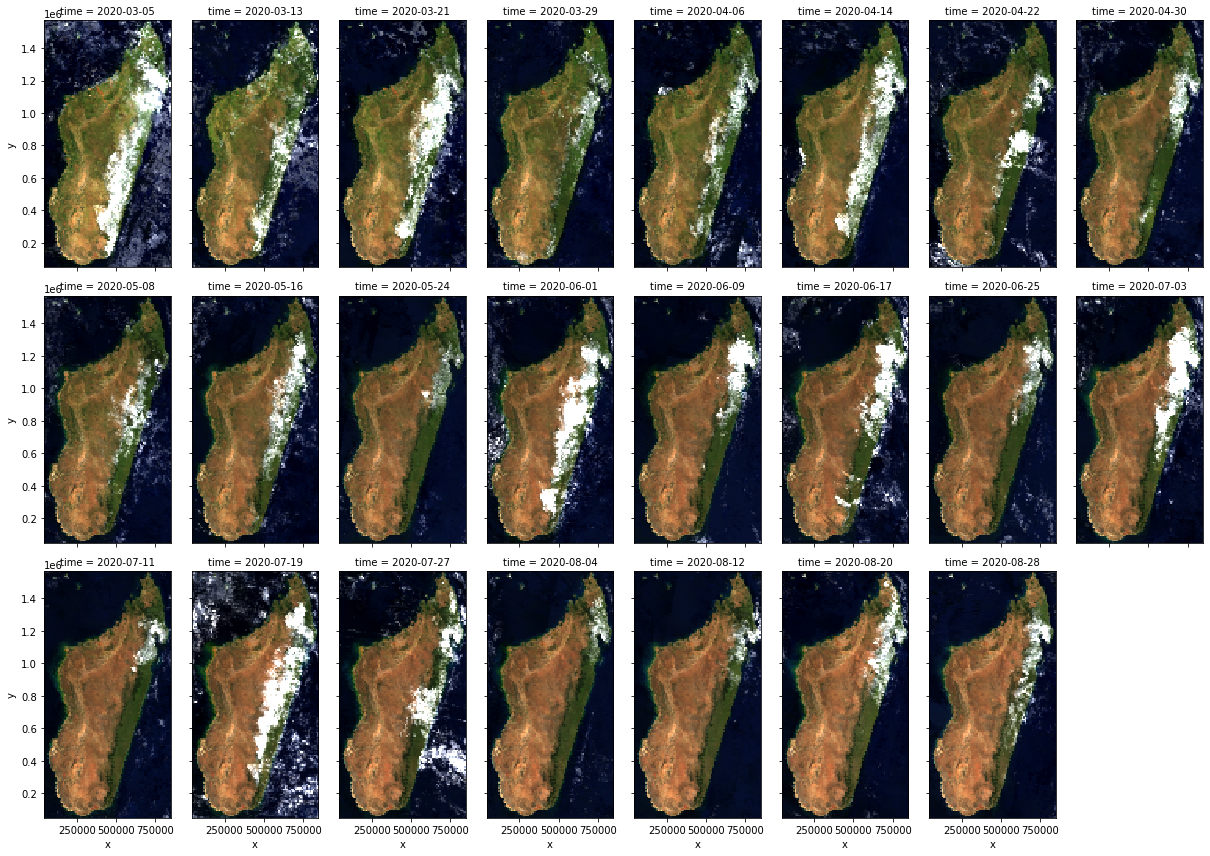

In [5]:
ds.wx.rgb(stretch=0.98, col_wrap=8, size=4, aspect=0.5)

As you can see, the images above are natural color composites. That's because we downloaded the bands in the R, G, B, NIR order. The `rgb` method defaults to using the first three bands as the red, green, and blue channels. If we want a false color composite, we can specify a `bands` argument in whatever order we want. Let's do NIR, R, G instead.

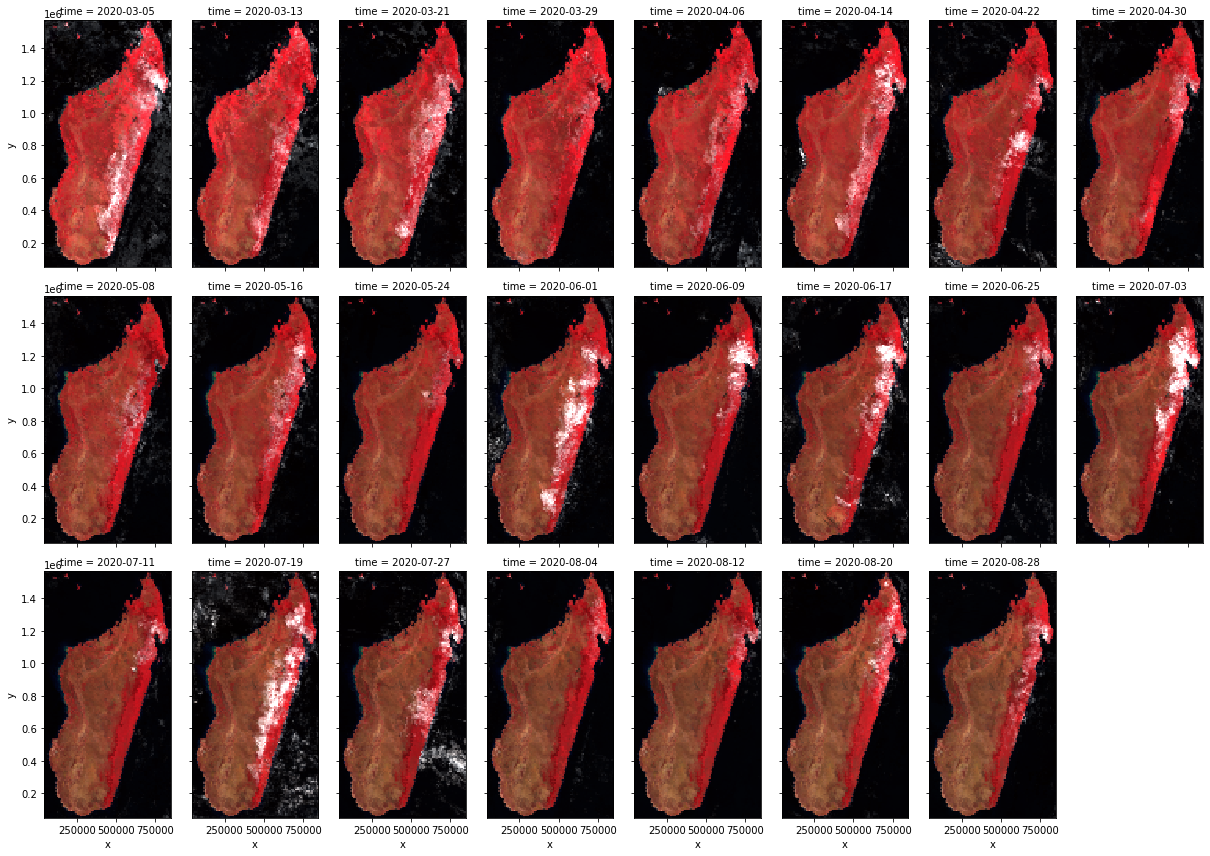

In [6]:
bands = ["sur_refl_b02", "sur_refl_b01", "sur_refl_b04"]

ds.wx.rgb(bands=bands, stretch=0.995, col_wrap=8, size=4, aspect=0.5)

## Interactive Plots

By default, the `rgb` method creates static plots. We can create interactive plots using [hvplot](https://github.com/holoviz/hvplot), which is an optional dependency of `wxee`. First, make sure it's installed, and then call `rgb` with the `interactive` argument.

In [ ]:
!pip install hvplot

In [7]:
ds.wx.rgb(stretch=0.98, interactive=True, frame_width=200, aspect=0.5)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=22, width=550)
        [2] HSpacer()